<a href="https://colab.research.google.com/github/gobi2001-2006/satellite-image-classsification-using-resnet-18-and-SVM/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # upload the kaggle.json file here


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gobikacom","key":"f09cdc92a40e5b652645af63ae464718"}'}

In [ ]:
!mv "kaggle (1).json" kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip EuroSAT.zip -d eurosat_data

Streaming output truncated to the last 5000 lines.
  inflating: eurosat_data/2750/SeaLake/SeaLake_2206.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1313.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_263.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_967.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_515.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1465.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1817.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2902.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2570.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1004.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_174.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2111.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2388.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_1948.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_838.jpg  
  inflating: eurosat_data/2750/SeaLake/SeaLake_2738.jpg  
  inflating: eurosat_data/

In [ ]:
rimport tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


In [ ]:
import os
import shutil
import random

# Path to the EuroSAT dataset
dataset_dir = "eurosat_data/2750"  # Make sure this is your EuroSAT dataset folder path
output_dir = "EuroSAT_split"  # Folder to store train/val split dataset

# Create target directories for training and validation data
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get all class names (subfolders inside the EuroSAT dataset)
class_names = os.listdir(dataset_dir)
class_names = [cls for cls in class_names if os.path.isdir(os.path.join(dataset_dir, cls))]

# Split data for each class
for class_name in class_names:
    # Define paths for each class
    class_path = os.path.join(dataset_dir, class_name)
    train_class_path = os.path.join(train_dir, class_name)
    val_class_path = os.path.join(val_dir, class_name)

    # Create directories for each class in train/val
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)

    # List all images in the current class folder
    image_files = os.listdir(class_path)
    image_files = [f for f in image_files if f.endswith('.jpg')]

    # Shuffle the list of images
    random.shuffle(image_files)

    # Split the images into train and validation (80% for training, 20% for validation)
    split_idx = int(0.8 * len(image_files))
    train_images = image_files[:split_idx]
    val_images = image_files[split_idx:]

    # Move images to respective folders
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_path, img))

    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_class_path, img))

    print(f"Class '{class_name}' split into {len(train_images)} train and {len(val_images)} val images.")

print("✅ Dataset split completed!")


Class 'PermanentCrop' split into 2000 train and 500 val images.
Class 'Residential' split into 2400 train and 600 val images.
Class 'Industrial' split into 2000 train and 500 val images.
Class 'Highway' split into 2000 train and 500 val images.
Class 'Pasture' split into 1600 train and 400 val images.
Class 'HerbaceousVegetation' split into 2400 train and 600 val images.
Class 'Forest' split into 2400 train and 600 val images.
Class 'SeaLake' split into 2400 train and 600 val images.
Class 'River' split into 2000 train and 500 val images.
Class 'AnnualCrop' split into 2400 train and 600 val images.
✅ Dataset split completed!


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

# Directory paths
train_dir = 'EuroSAT_split/train'
test_dir = 'EuroSAT_split/val'

# Define transformations for training and testing data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-18 requires 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained weights mean/std
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final layer to match the number of classes (10 classes for EuroSAT)
model.fc = nn.Linear(model.fc.in_features, 10)

# Send the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_preds / total_preds
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Save the trained model (in PyTorch format)
model_save_path = "resnet18_eurosat_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Optionally, save the model architecture along with weights (for full restoration later)
torch.save(model, "resnet18_eurosat_full_model.pth")
print("Model architecture and weights saved together.")



Epoch [1/5], Loss: 0.4192, Accuracy: 0.8648
Epoch [2/5], Loss: 0.2402, Accuracy: 0.9223
Epoch [3/5], Loss: 0.1902, Accuracy: 0.9374
Epoch [4/5], Loss: 0.1510, Accuracy: 0.9503
Epoch [5/5], Loss: 0.1289, Accuracy: 0.9567
Model saved to resnet18_eurosat_model.pth
Model architecture and weights saved together.


Predicted class: HerbaceousVegetation
Confidence score: 1.0000


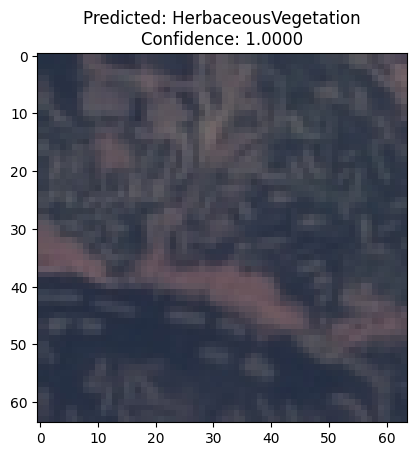

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the model architecture with the correct number of output classes (10 for EuroSAT)
model = models.resnet18(weights=None)  # Load a fresh ResNet18 model

# Modify the final fully connected layer to match the number of classes
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Adjust to 10 classes (EuroSAT)

# Load the model weights (excluding the final fc layer)
model.load_state_dict(torch.load('resnet18_eurosat_model.pth'))

# Set the model to evaluation mode
model.eval()

# Image Preprocessing
def preprocess_image(image_path):
    # Define the required transformations (resize, normalize, etc.)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for ImageNet
    ])

    # Open the image and apply the transformations
    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img)

    # Add a batch dimension since the model expects a batch of images
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor

# Make prediction with confidence score
def predict_with_confidence(image_path):
    img_tensor = preprocess_image(image_path)

    # Run the image through the model
    with torch.no_grad():  # Turn off gradients for inference
        outputs = model(img_tensor)

    # Get the predicted class (index of the max output)
    _, predicted_class = torch.max(outputs, 1)

    # Get the confidence score for the predicted class
    confidence_score = torch.softmax(outputs, dim=1)[0][predicted_class].item()

    return predicted_class.item(), confidence_score

# Example usage
image_path = 'h.jpg'  # Provide the path to your image
predicted_class, confidence_score = predict_with_confidence(image_path)

# Assuming you have a list of class names (for EuroSAT, replace it with your actual class names)
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Display the prediction and confidence score
print(f'Predicted class: {class_names[predicted_class]}')
print(f'Confidence score: {confidence_score:.4f}')

# Optionally, show the image along with the predicted class and confidence score
img = Image.open(image_path)
plt.imshow(img)
plt.title(f'Predicted: {class_names[predicted_class]}\nConfidence: {confidence_score:.4f}')
plt.show()
